In [1]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle,Circle

from scipy.stats import chi2
from scipy.io import loadmat
import time

from lanczos_bin import *
#from lanczos_bin import mystep,distribution

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

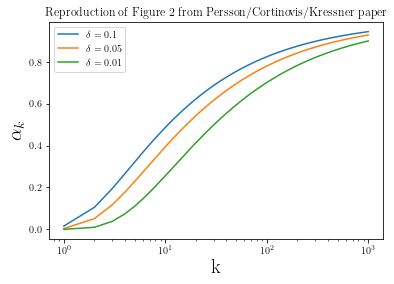

In [3]:
def alphaFun(delta,k):
    return chi2.isf(1-delta,df=k)/k

def sampleC(epsilon,delta):
    return 4*np.log(2/delta)/epsilon**2

def inv_perm(e):
    inve = np.copy(e)
    inve[e] = np.arange(len(e))
    return inve
   
ks = np.arange(1,1000)

plt.figure()
for delta in [0.1,0.05,0.01]:
    plt.semilogx(ks,alphaFun(delta,ks))
    
plt.legend([r'$\delta = 0.1$',r'$\delta = 0.05$',r'$\delta = 0.01$'])
plt.title("Reproduction of Figure 2 from Persson/Cortinovis/Kressner paper")
plt.xlabel('k',fontsize=20)
plt.ylabel(r'$\alpha_k$',fontsize=20)
plt.show()

In [17]:
# Estrada index on Roget graph
P = loadmat('rog.mat')
A = P['A']
B = A.toarray()
λ = np.linalg.eigh(B)[0]

delta = 0.05
b = 2
n = 30
f = lambda x : np.exp(x)
texact = sum(f(λ))
print(texact)

2.3799770208989445e+05


In [9]:
# Log determinant of ThermomechTC matrix
P = loadmat('therm.mat')
A = P['A']

delta = 0.05
b = 2
n = 35
f = lambda x : np.log(x)
texact = -546787


In [11]:
# Nuclear norm estimation
d = 2500
c = 1.5
λ = np.arange(1,d+1)**(-c)
A = sp.sparse.diags(λ)

delta = 0.05
b = 2
n = 50
#f = lambda x : np.sqrt(x)
f = lambda x : np.sqrt(np.maximum(x,0))
texact = sum(f(λ))
epsilon = 0.1*texact
print(texact)

24.844400003368424


In [19]:
ntrials = 10
ps =  range(6,10)
KRY = np.zeros((4,ntrials*len(ps)))
HPP = np.zeros((4,ntrials*len(ps)))

k = 0
for (i,p) in enumerate(ps):
    print(i)
    for j in range(ntrials):
        print(j,end='')
        epsilon = abs(texact) * 2**(-p)
        t, c, r = ada_krylov(A,f,b,n,epsilon,delta)
        KRY[0,k] = abs(t-texact)/abs(texact)
        KRY[1,k] = c+r
        KRY[2,k] = c
        KRY[3,k] = r
        
        t, c, r = ada_hpp(A,f,n,epsilon,delta)
        HPP[0,k] = abs(t-texact)/abs(texact)
        HPP[1,k] = c+r
        HPP[2,k] = c
        HPP[3,k] = r
        
        k = k + 1

0
01234567891
01234567892
01234567893
0123456789

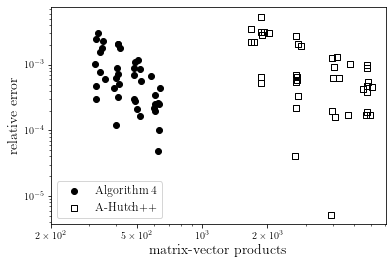

In [20]:
plt.figure()
plt.xlabel("matrix-vector products",fontsize=14)
plt.ylabel("relative error",fontsize=14)

ax = plt.gca()
ax.scatter(KRY[1,:],abs(KRY[0,:]),c='black')
ax.scatter(HPP[1,:],abs(HPP[0,:]),c='none',marker="s",edgecolors='black')

ax.set_yscale('log')
ax.set_xscale('log')
plt.legend(["Algorithm 4","A-Hutch++"],fontsize=12)


# plt.xticks([200., 500., 1000., 2000.],[ '$\\mathdefault{2\\times 10^{2}}$', \
#                                        '$\\mathdefault{5\\times 10^{2}}$', \
#                                         '$\\mathdefault{10^{3}}$', \
#                                         '$\\mathdefault{2\\times 10^{3}}$']) # Estrada index

# plt.xticks([300., 1000., 3000.,10000],[ '$\\mathdefault{3\\times 10^{2}}$', \
#                                        '$\\mathdefault{10^{3}}$', \
#                                         '$\\mathdefault{3\\times 10^{3}}$', \
#                                         '$\\mathdefault{10^{4}}$']) # Nuclear norm

plt.xticks([200., 500., 1000., 2000.],[ '$\\mathdefault{2\\times 10^{2}}$', \
                                       '$\\mathdefault{5\\times 10^{2}}$', \
                                        '$\\mathdefault{10^{3}}$', \
                                        '$\\mathdefault{2\\times 10^{3}}$']) # Log determinant

plt.show()
#plt.savefig('figures/logdet-thermo.pdf',bbox_inches='tight')


In [36]:
lp = len(ps)

Kdfl = np.reshape(KRY[2,:],(lp,ntrials))
Krem = np.reshape(KRY[3,:],(lp,ntrials))
Kmd  = np.mean(Kdfl,axis=1)
Kmr  = np.mean(Krem,axis=1)

Hdfl = np.reshape(HPP[2,:],(lp,ntrials))
Hrem = np.reshape(HPP[3,:],(lp,ntrials))
Hmd  = np.mean(Hdfl,axis=1)
Hmr  = np.mean(Hrem,axis=1)

dat = np.zeros((lp,11))
dat[:,0] = np.array(ps)[:lp]
dat[:,1] = Kmd - (n-1)*b
dat[:,2] = Kmr/n
dat[:,3] = Kmd
dat[:,4] = Kmr
dat[:,5] = Kmd+Kmr
dat[:,6] = Hmd/(2*n)
dat[:,7] = Hmr/n
dat[:,8] = Hmd
dat[:,9] = Hmr
dat[:,10] = Hmd+Hmr

#np.set_printoptions(precision=4)
np.set_printoptions(linewidth=160)
np.set_printoptions(suppress=True)
print(dat)


[[   6.    6.    4.   74.  140.  214.    3.    4.  210.  140.  350.]
 [   7.    6.    8.   74.  280.  354.    3.    8.  210.  280.  490.]
 [   8.    6.   19.   74.  665.  739.    3.   19.  210.  665.  875.]
 [   9.    6.   55.   74. 1925. 1999.    3.   55.  210. 1925. 2135.]]


In [12]:
# Estrada index on Roget graph
P = loadmat('rog.mat')
A = P['A']
B = A.toarray()
λ = np.linalg.eigh(B)[0]

delta = 0.05
bs = [1,2,4,8]
n = 30
f = lambda x : np.exp(x)
texact = sum(f(λ))
print(texact)

237997.7020898951


In [28]:
ntrials = 10
ps =  range(2,8)
KRY = np.zeros((4,ntrials*len(ps)))
HPP = np.zeros((4,ntrials*len(ps)))

dat = np.zeros((len(ps),3*len(bs)+1))
errs = np.zeros((len(ps)*ntrials,len(bs)))
costs = np.zeros((len(ps)*ntrials,len(bs)))
times = np.zeros((len(ps), len(bs)+1))
for (i,p) in enumerate(ps):
    print(i)
    dat[i,0] = p
    for j in range(ntrials):
        for (l,b) in enumerate(bs):
            epsilon = abs(texact) * 2**(-p)
            
            start = time.time()
            t, c, r = ada_krylov(A,f,b,n,epsilon,delta)
            end = time.time()
            
            errs[i*ntrials+j,l] += abs(t-texact)/abs(texact)
            costs[i*ntrials+j,l] += c+r
            
            dat[i,3*l+1] += (c - (n-1)*b)/ntrials
            dat[i,3*l+2] += (r/n)/ntrials
            dat[i,3*l+3] += (c+r)/ntrials
            
            times[i,l] += (end-start)/ntrials
            
            
        start = time.time()
        t, c, r = ada_hpp(A,f,n,epsilon,delta)
        end = time.time()
        
        times[i,-1] += (end-start)/ntrials
            
            
            
            

0
1
2
3
4
5


In [23]:
start = time.time()
xs = np.linalg.eigvalsh(A.toarray())
end = time.time()
print(end-start)



0.12191486358642578


In [27]:
np.set_printoptions(linewidth=160)
np.set_printoptions(suppress=True)
print(dat)
print(times)

[[  2.   24.7   2.8 137.7  31.2   2.6 167.2  44.4   2.3 229.4  72.    2.  364. ]
 [  3.   35.    3.3 163.   44.4   3.  192.4  55.6   3.  261.6  81.6   2.3 382.6]
 [  4.   52.3   3.9 198.3  59.6   3.9 234.6  70.4   3.9 303.4  98.4   3.  420.4]
 [  5.   89.8   4.5 253.8 103.    3.9 278.  111.6   3.7 338.6 131.2   3.5 468.2]
 [  6.  121.8   5.6 318.8 142.6   4.7 341.6 157.2   4.2 399.2 174.4   4.  526.4]
 [  7.  159.9   7.6 416.9 199.6   4.9 404.6 212.4   4.5 463.4 232.8   4.  584.8]]
[[0.03046234 0.0392961  0.05871542 0.14256659 0.04900894]
 [0.0365566  0.05202467 0.07205899 0.16583805 0.05799818]
 [0.05963538 0.07709167 0.0974606  0.18598852 0.09613211]
 [0.14812999 0.1554131  0.17015026 0.2642452  0.11893299]
 [0.28965497 0.28247063 0.32528892 0.44710088 0.22394357]
 [0.46593521 0.4908128  0.47061074 0.65035951 0.30805638]]


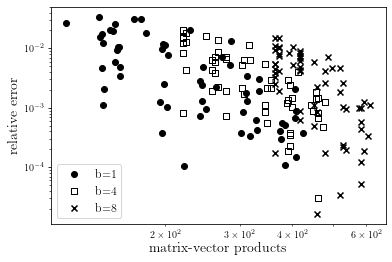

In [13]:
plt.figure()
plt.xlabel("matrix-vector products",fontsize=14)
plt.ylabel("relative error",fontsize=14)

ax = plt.gca()
ax.scatter(costs[:,0],abs(errs[:,0]),c='black')
ax.scatter(costs[:,1],abs(errs[:,1]),c='none',marker="s",edgecolors='black')
ax.scatter(costs[:,2],abs(errs[:,2]),c='black',marker="x")
#for p in ps:
#    plt.axhline(y=2**(-p), color='k', linestyle=':')
ax.set_yscale('log')
ax.set_xscale('log')
plt.legend(["b=1","b=4","b=8"],fontsize=12)
#plt.show()
plt.savefig('figures/roget-blocks2.pdf',bbox_inches='tight')

In [26]:
print(A.shape)
print(A.nnz)

(1022, 1022)
7297
